In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy.spatial import KDTree


In [20]:
# Greedy search for 4-line cycles
def find_loops(adjacency):
	loops = set()
	for a in adjacency:
		for b in adjacency[a]:
			for c in adjacency[b]:
				if c == a: continue
				for d in adjacency[c]:
					if d == a or d == b: continue
					if a in adjacency[d]:  # closes the loop
						loop = tuple(sorted([a, b, c, d]))
						loops.add(loop)
	return list(loops)

def angle_between_lines(line1, line2):
	def unit(v): return v / np.linalg.norm(v)
	v1 = unit(np.subtract(line1[1], line1[0]))
	v2 = unit(np.subtract(line2[1], line2[0]))
	angle = np.degrees(np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0)))
	return angle

def is_reasonable_quad(loop, segments):
	lines = [segments[i] for i in loop]
	angles = []
	for i in range(4):
		angle = angle_between_lines(lines[i], lines[(i+1) % 4])
		angles.append(angle)
	return all(60 <= a <= 120 for a in angles)

def create_mask_from_loops(loops, segments, image_shape):
	mask = np.zeros(image_shape[:2], dtype=np.uint8)
	
	for loop in loops:
		if is_reasonable_quad(loop, segments):
			# Get the four corner points of the quadrilateral
			lines = [segments[i] for i in loop]
			points = []
			for line in lines:
				points.extend([line[0], line[1]])
			
			# Find unique corner points by clustering nearby points
			unique_points = []
			for point in points:
				if not any(np.linalg.norm(np.array(point) - np.array(up)) < 10 for up in unique_points):
					unique_points.append(point)
			
			if len(unique_points) >= 4:
				# Use first 4 points to form quadrilateral
				quad_points = np.array(unique_points[:4], dtype=np.int32)
				cv2.fillPoly(mask, [quad_points], 1)
	
	return mask

def get_keylines(image):
	# LSD Line Segment Detector
	lsd = cv2.line_descriptor.LSDDetector.createLSDDetector()
	keylines_raw = lsd.detect(image, scale=2, numOctaves=3)

	# Prepare line endpoints
	segments = [((line.startPointX, line.startPointY), (line.endPointX, line.endPointY)) for line in keylines_raw]
	points = [pt for seg in segments for pt in seg]

	print(f"Detected {len(segments)} line segments.")

	if len(segments) < 4:
		return [], np.zeros(image.shape[:2], dtype=np.uint8)

	# Build KDTree for fast proximity search
	kdtree = KDTree(points)
	point_to_lines = defaultdict(set)

	for i, (p1, p2) in enumerate(segments):
		point_to_lines[p1].add(i)
		point_to_lines[p2].add(i)

	# Build fast adjacency list based on endpoint proximity
	adjacency = defaultdict(set)
	for i, (p1, p2) in enumerate(segments):
		for p in [p1, p2]:
			idxs = kdtree.query_ball_point(p, r=5.0)
			for j in idxs:
				other_line_idx = j // 2
				if other_line_idx != i:
					adjacency[i].add(other_line_idx)
	
	# Find and filter quads
	loops = find_loops(adjacency)
	rectangle_lines = set()

	for loop in loops:
		if is_reasonable_quad(loop, segments):
			rectangle_lines.update(loop)

	# Filtered output
	filtered_keylines = [keylines_raw[i] for i in rectangle_lines]
	
	# Create mask
	mask = create_mask_from_loops(loops, segments, image.shape)
	
	return filtered_keylines, mask


Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/photo_2025-03-15_18-14-39.jpg
Detected 1301 line segments.


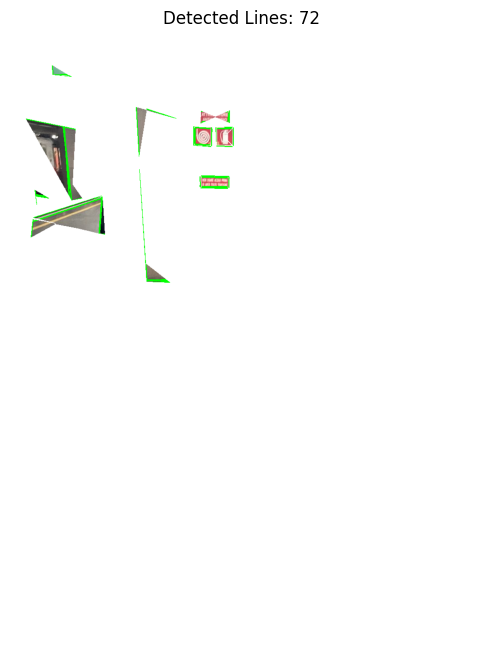

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00006.jpeg
Detected 2996 line segments.


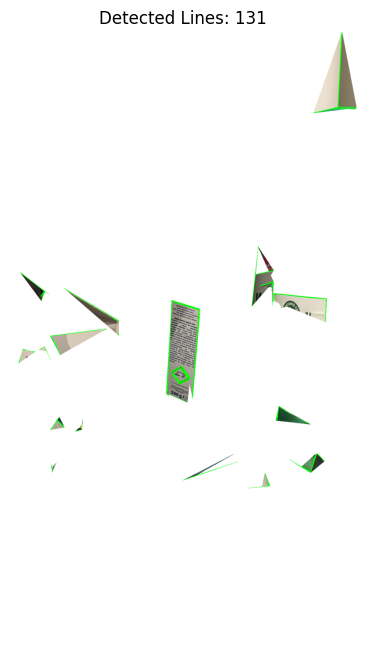

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00007.jpeg
Detected 0 line segments.
No keylines found.
Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00016.jpg
Detected 638 line segments.


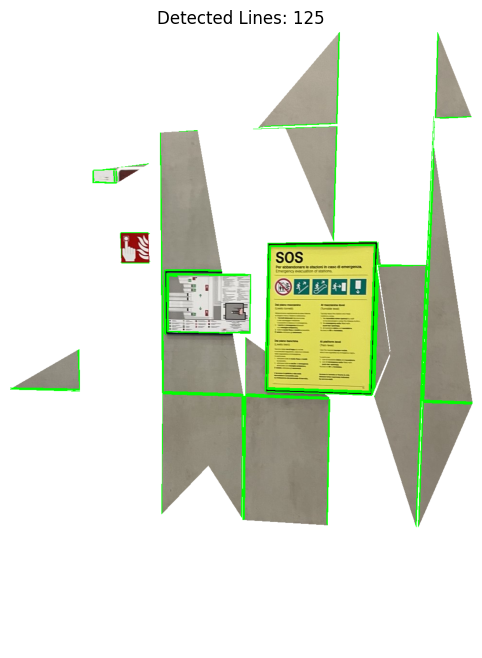

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00000.jpg
Detected 10637 line segments.


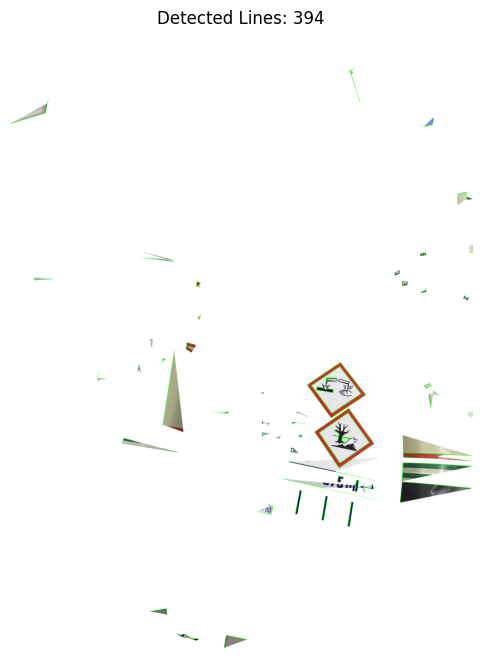

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00015.jpg
Detected 328 line segments.


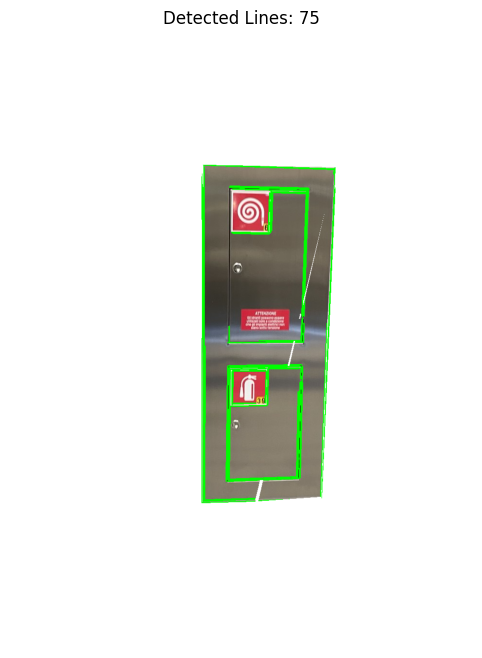

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00011.jpg
Detected 354 line segments.


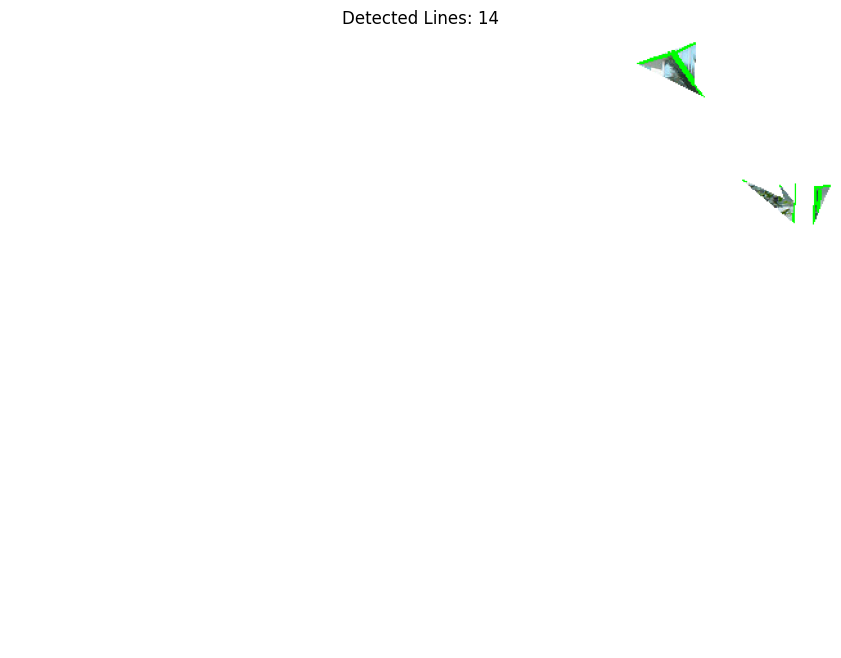

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00010.jpg
Detected 271 line segments.


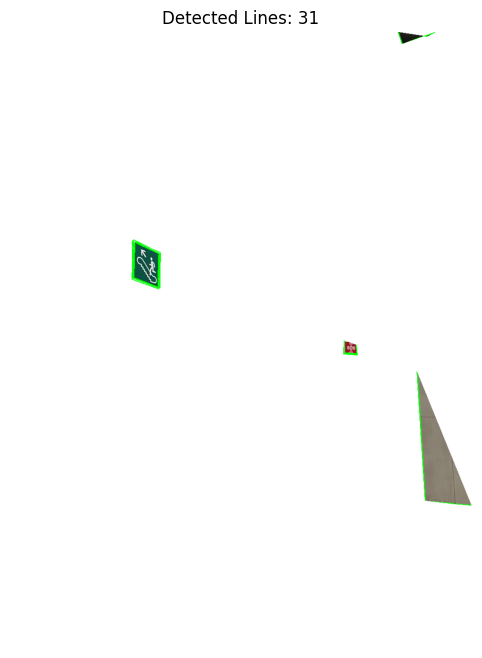

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00001.jpeg
Detected 864 line segments.


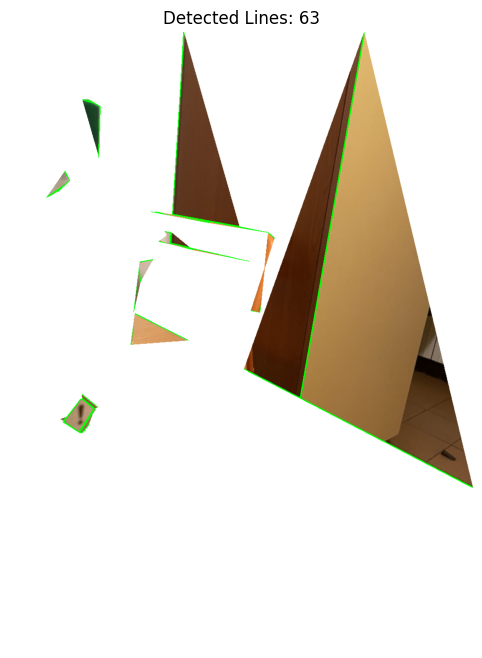

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00012.jpg
Detected 639 line segments.


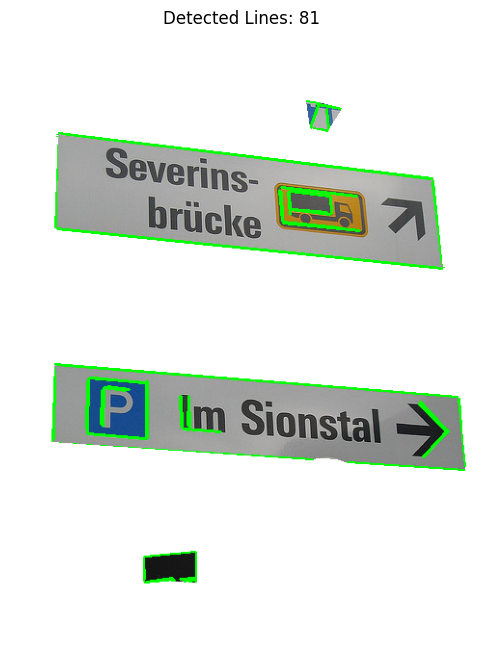

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00013.jpg
Detected 447 line segments.


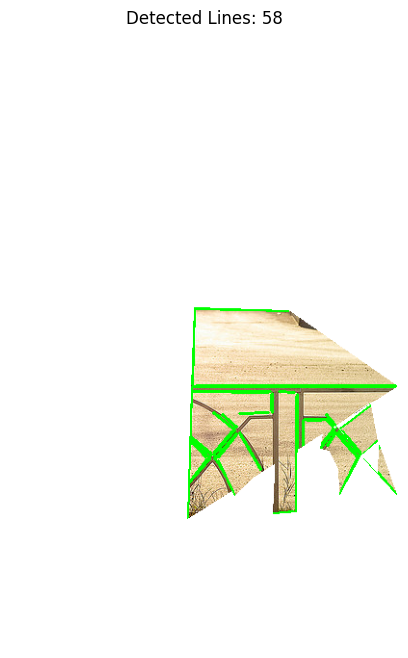

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00002.jpeg
Detected 820 line segments.


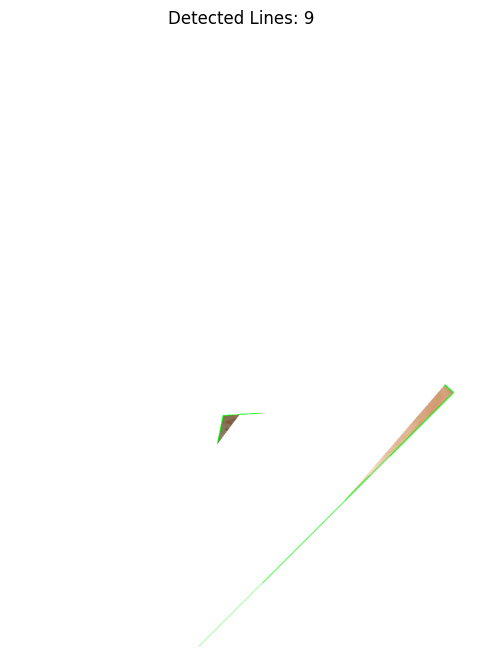

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/photo_2025-03-15_18-14-44.jpg
Detected 3023 line segments.


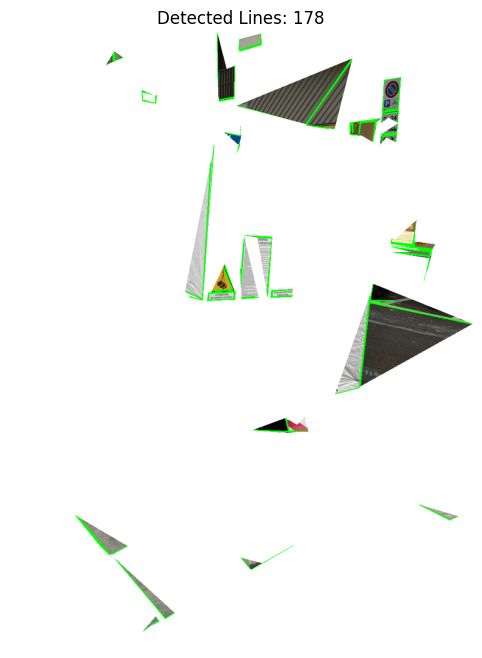

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/photo_2025-03-15_18-14-51.jpg
Detected 3260 line segments.


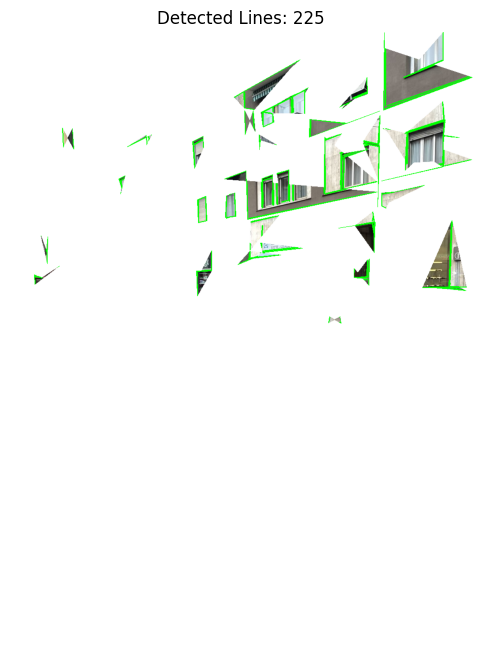

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/photo_2025-03-15_18-14-47.jpg
Detected 1126 line segments.


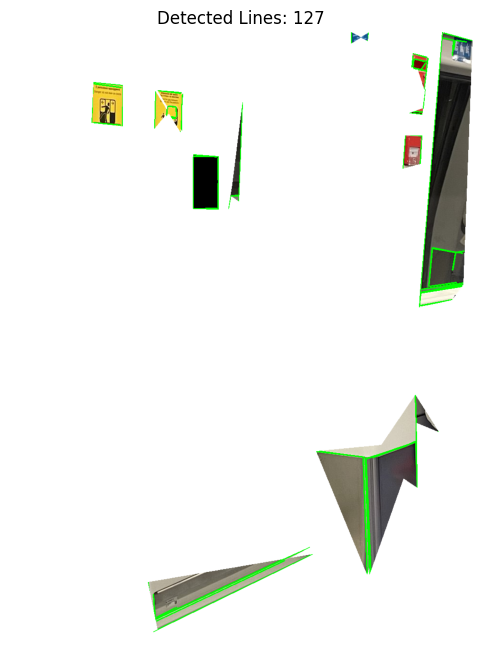

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/road185.png
Detected 465 line segments.


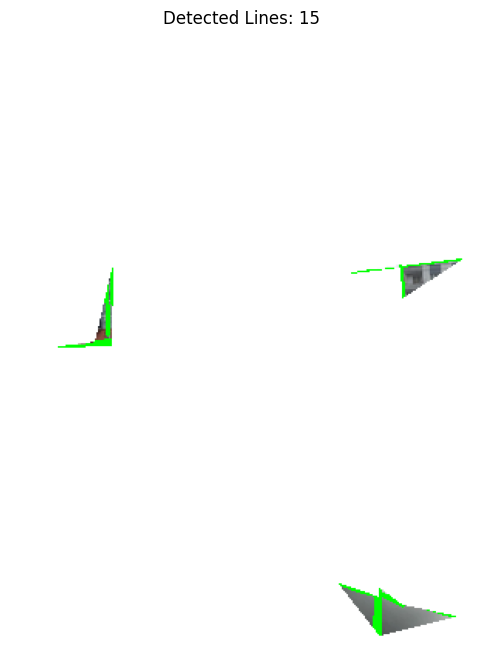

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00003.jpeg
Detected 1142 line segments.


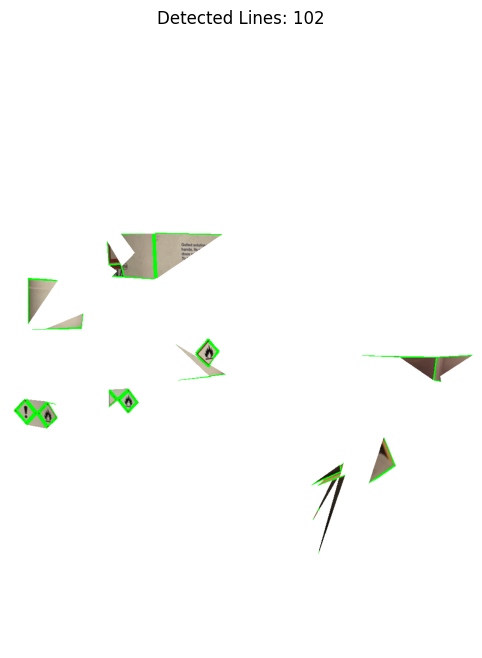

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00008.jpeg
Detected 1628 line segments.


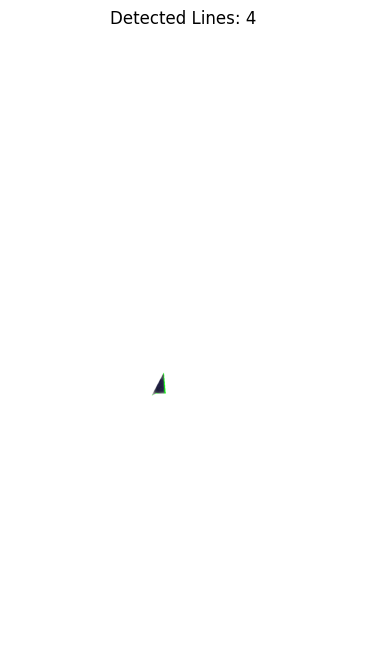

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00004.jpeg
Detected 1812 line segments.


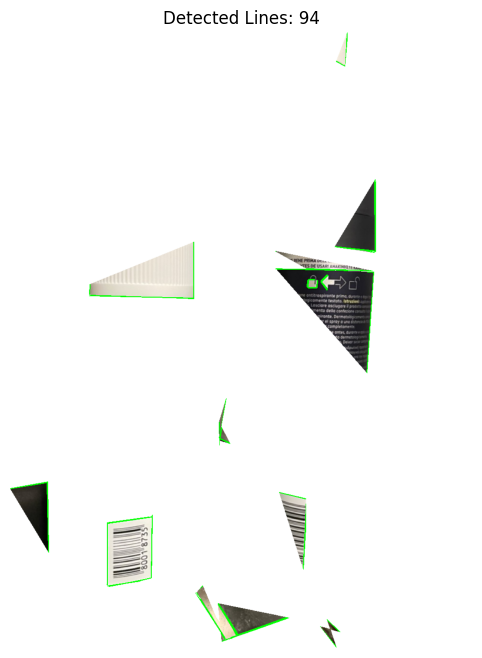

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00005.jpeg
Detected 1734 line segments.


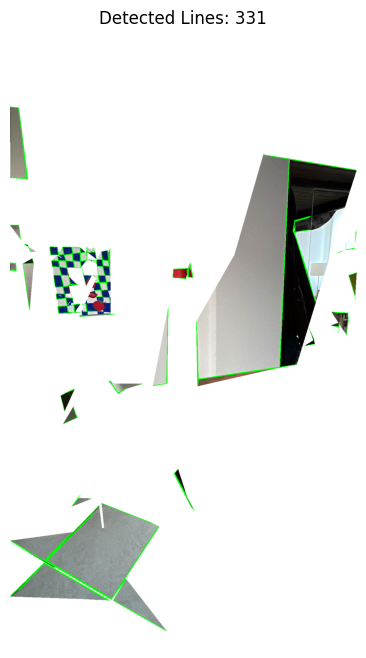

Processing /Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive/positive_00009.jpeg
Detected 4215 line segments.


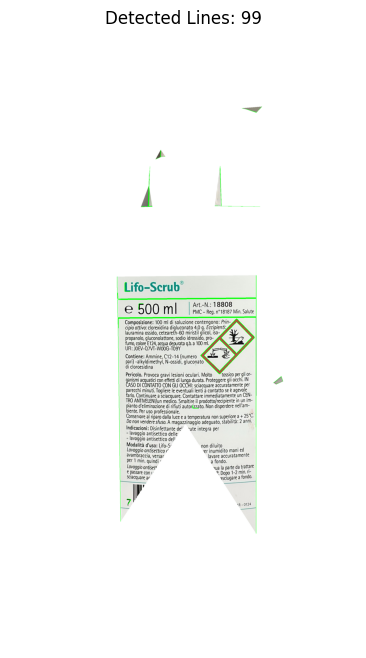

In [22]:
images_folder = "/Users/frbuccoliero/Desktop/Thesis/Tests/template_matching/dataset/images/positive"
image_paths = []
for root, dirs, files in os.walk(images_folder):
	for file in files:
		if file.lower().endswith(('.png', '.jpg', '.jpeg')):
			image_paths.append(os.path.join(root, file))

for image_path in image_paths:
	print(f"Processing {image_path}")
	
	image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

	# Get keylines
	filtered_keylines, mask = get_keylines(image)

	if not filtered_keylines:
		print("No keylines found.")
		continue

	img_with_lines = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

	# Draw the detected keylines
	for keyline in filtered_keylines:
		pt1 = (int(keyline.startPointX), int(keyline.startPointY))
		pt2 = (int(keyline.endPointX), int(keyline.endPointY))
		cv2.line(img_with_lines, pt1, pt2, (0, 255, 0), 2)

	plt.figure(figsize=(12, 8))
	masked_img = img_with_lines.copy()
	masked_img[mask == 0] = [255, 255, 255]  # Set background to white where mask is 0
	plt.imshow(masked_img)
	plt.title(f'Detected Lines: {len(filtered_keylines)}')
	plt.axis('off')
	plt.show()

